In [ ]:
!pip install python-graphblas[default]

In [2]:
import graphblas as gb
gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder, Vector, Scalar
from graphblas.io import mmread
import numpy as np
import time
import timeit
from functools import partial
import pandas as pd
import random

## Задача 1

 * Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Levels) в ширину из нескольких заданных стартовых вершин.
 Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.  

 * Функция возвращает массив пар: стартовая вершина, и массив (levels), где для каждой вершины указано, на каком уровне она достижима из этой стартовой. Стартовая вершина достижима на нулевом уровне, если вершина не достижима, то значение соответствующей ячейки сделайте равной -1.

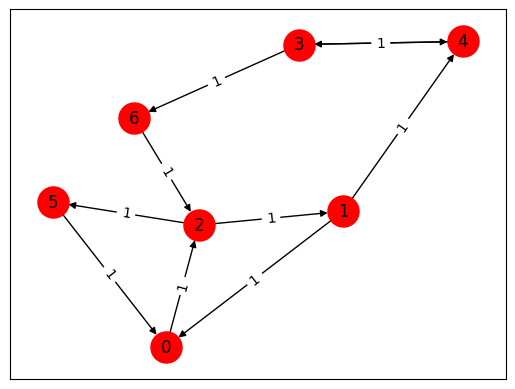

In [3]:
edges = [
    [2, 4, 1, 0, 3, 2, 3, 5, 6, 1],
    [1, 3, 0, 2, 4, 5, 6, 0, 2, 4],
]

A = Matrix.from_coo(edges[0], edges[1], [1] * len(edges[0]))
gb.viz.draw(A.dup(mask=A.dup(dtype=dtypes.BOOL)))

In [4]:
def calculate_msbfs_levels(graph, start_points, semiring=semiring.lor_land):
    level_results = []
    total_nodes = graph.nrows

    if not isinstance(start_points, list):
        start_points = [start_points]

    for point in start_points:
        level_vector = Vector(dtypes.INT32, total_nodes)
        visited = Vector(bool, total_nodes)
        visited[point] << True
        is_successor = Scalar(bool)
        current_level = 0

        for _ in range(total_nodes):
            level_vector(mask=visited.V) << current_level
            current_level += 1
            visited(~level_vector.S, replace=True) << visited.vxm(graph, semiring)

        level_vector(~level_vector.S) << -1
        node_levels = [(i, level_vector.get(i, default=-1)) for i in range(total_nodes)]
        level_results.append((point, node_levels))

    return level_results

In [5]:
# старт из 2 и 3 точки
calculate_msbfs_levels(A, [2, 3])

[(2, [(0, 2), (1, 1), (2, 0), (3, 3), (4, 2), (5, 1), (6, 4)]),
 (3, [(0, 4), (1, 3), (2, 2), (3, 0), (4, 1), (5, 3), (6, 1)])]

In [6]:
# старт из 4 точки
calculate_msbfs_levels(A, 4)

[(4, [(0, 5), (1, 4), (2, 3), (3, 1), (4, 0), (5, 4), (6, 2)])]

## Задача 2

 * Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.  

 * Функция возвращает массив пар: стартовая вершина, и массив (parents), где для каждой вершины графа указано, из какой вершины мы пришли в эту по кратчайшему пути из стартовой вершины. При этом для самой стартовой вершины такое значение взять равное -1, а для недостижимых вершин взять равное -2. При наличии нескольких возможных значений в массивах parents брать наименьшее.

In [7]:
def find_parents_msbfs(matrix, start_points, semiring=semiring.min_first):
    results_list = []
    total_nodes = matrix.nrows
    if not isinstance(start_points, list):
        start_points = [start_points]
    for start in start_points:
        node_indices = Vector(dtypes.INT32, total_nodes)
        node_indices.build(range(total_nodes), range(total_nodes))
        parent_nodes = Vector(dtypes.INT32, total_nodes)
        parent_nodes[start] << -1
        current_wave = Vector(dtypes.INT32, total_nodes)
        current_wave[start] << -1
        while current_wave.nvals > 0:
            current_wave << node_indices.ewise_mult(current_wave, binary.first)
            current_wave(~parent_nodes.S, replace=True) << current_wave.vxm(matrix, semiring)
            parent_nodes(binary.plus) << current_wave
        parent_nodes(~parent_nodes.S) << -2
        parent_mapping = [(node, parent_nodes.get(node, default=-1)) for node in range(total_nodes)]
        results_list.append((start, parent_mapping))
    return results_list

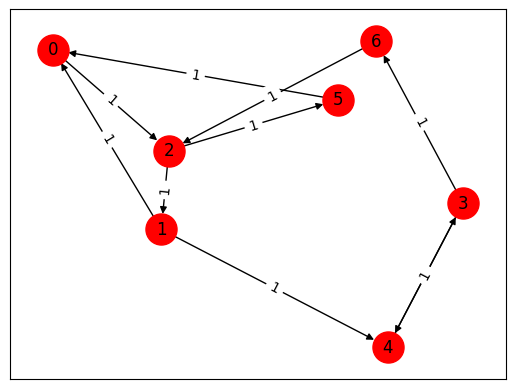

In [8]:
gb.viz.draw(A.dup(mask=A.dup(dtype=dtypes.BOOL)))

In [9]:
# старт из 2 и 3 точки
find_parents_msbfs(A, [2, 3])

[(2, [(0, 1), (1, 2), (2, -1), (3, 4), (4, 1), (5, 2), (6, 3)]),
 (3, [(0, 1), (1, 2), (2, 6), (3, -1), (4, 3), (5, 2), (6, 3)])]

In [10]:
# старт из 4 точки
find_parents_msbfs(A, 4)

[(4, [(0, 1), (1, 2), (2, 6), (3, 4), (4, -1), (5, 2), (6, 3)])]

## Тесты для проверки алгоритмов

**Задание:** Добавить тесты для проверки корректности полученных реализаций.

In [11]:
def test_calculate_msbfs_levels():
    edges = [
    [2, 4, 1, 0, 3, 2, 3, 5, 6, 1],
    [1, 3, 0, 2, 4, 5, 6, 0, 2, 4],
    ]
    graph = Matrix.from_coo(edges[0], edges[1], [1] * len(edges[0]))

    # Тест 1: Проверка уровней для одной стартовой точки
    result = calculate_msbfs_levels(graph, [0])
    assert result == [(0, [(0, 0), (1, 2), (2, 1), (3, 4), (4, 3), (5, 2), (6, 5)])]

    # Тест 2: Проверка уровней для нескольких стартовых точек
    result = calculate_msbfs_levels(graph, [0, 3])
    assert result == [
        (0, [(0, 0), (1, 2), (2, 1), (3, 4), (4, 3), (5, 2), (6, 5)]),
     (3, [(0, 4), (1, 3), (2, 2), (3, 0), (4, 1), (5, 3), (6, 1)])
     ]

    # Тест 3: Граф с изолированными узлами
    edges = [
        [0, 1],
        [1, 0],
    ]
    graph = Matrix.from_coo(edges[0], edges[1], [1] * len(edges[0]), nrows=4, ncols=4)
    result = calculate_msbfs_levels(graph, [0])
    assert result == [(0, [(0, 0), (1, 1), (2, -1), (3, -1)])]
    print("Успешно!")

In [12]:
def test_find_parents_msbfs():
    edges = [
    [2, 4, 1, 0, 3, 2, 3, 5, 6, 1],
    [1, 3, 0, 2, 4, 5, 6, 0, 2, 4],
    ]
    graph = Matrix.from_coo(edges[0], edges[1], [1] * len(edges[0]))

    # Тест 1: Проверка поиска родителей для одной стартовой точки
    result = find_parents_msbfs(graph, [0])
    assert result == [(0, [(0, -1), (1, 2), (2, 0), (3, 4), (4, 1), (5, 2), (6, 3)])]

    # Тест 2: Проверка поиска родителей для нескольких стартовых точек
    result = find_parents_msbfs(graph, [0, 3])
    assert result == [
        (0, [(0, -1), (1, 2), (2, 0), (3, 4), (4, 1), (5, 2), (6, 3)]),
        (3, [(0, 1), (1, 2), (2, 6), (3, -1), (4, 3), (5, 2), (6, 3)])
    ]

    # Тест 3: Граф с изолированными узлами
    edges = [
        [0, 1],
        [1, 0],
    ]
    graph = Matrix.from_coo(edges[0], edges[1], [1] * len(edges[0]), nrows=4, ncols=4)
    result = find_parents_msbfs(graph, [0])
    assert result == [(0, [(0, -1), (1, 0), (2, -2), (3, -2)])]
    print("Успешно!")

In [13]:
test_calculate_msbfs_levels()
test_find_parents_msbfs()

Успешно!
Успешно!


## Проверка производительности на тестовых графах

 (+2 балла) Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных.  
 При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин.

In [ ]:
!gdown 1zRLt0DWI5J_tb8q3AoNukjR2n1b_tvc6
!unzip graphs.zip
!rm -rf graphs.zip

In [14]:
import time
import os
import matplotlib.pyplot as plt

In [15]:
def calculate_time(A, start_points):
    start_time = time.time()
    calculate_msbfs_levels(A, start_points)
    level_time = time.time() - start_time

    start_time = time.time()
    find_parents_msbfs(A, start_points)
    parents_time = time.time() - start_time

    return level_time, parents_time

In [60]:
results = {}
for filename in os.listdir('graphs'):
    if filename.endswith('.mtx'):
        filepath = os.path.join('graphs', filename)
        M = mmread(filepath)
        nonzero_count = M.nvals
        times = calculate_time(M, [1,2])
        results[nonzero_count] = times
results = dict(sorted(results.items()))

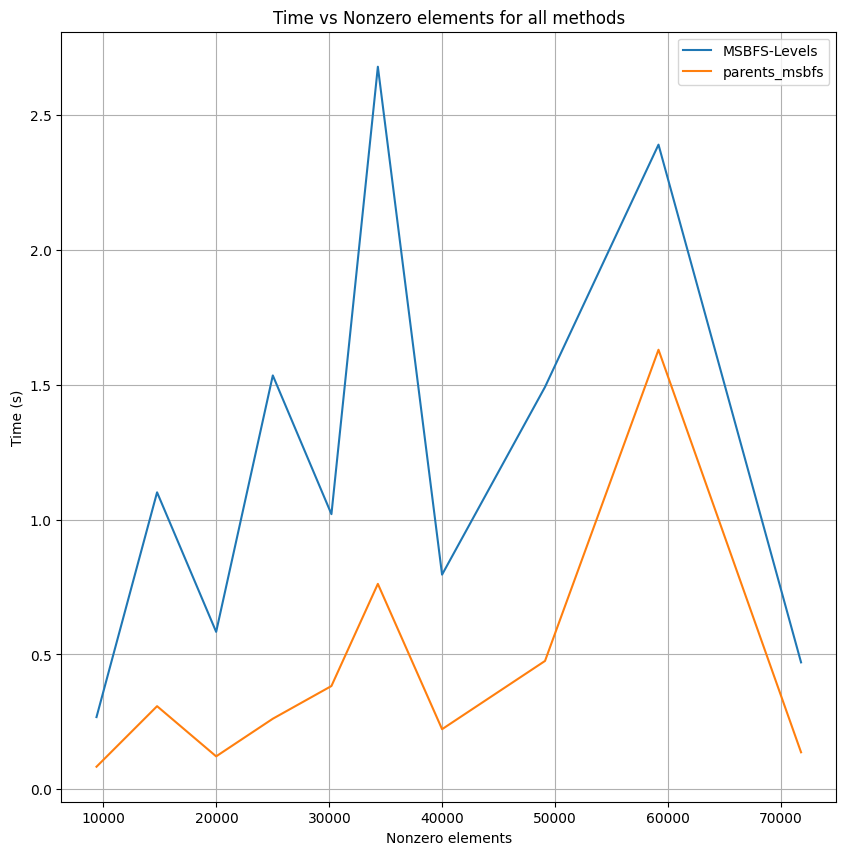

In [61]:
nonzero_count_list = list(results.keys())
level_time = [results[count][0] for count in nonzero_count_list]
parents_time = [results[count][1] for count in nonzero_count_list]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(nonzero_count_list, level_time, label='MSBFS-Levels')
ax.plot(nonzero_count_list, parents_time, label='parents_msbfs')
ax.set_xlabel('Nonzero elements')
ax.set_ylabel('Time (s)')
ax.set_title('Зависимость от размера графа для двух стартовых точек')
ax.legend()
ax.grid(True)

In [34]:
results = {}
for filename in os.listdir('graphs'):
    if filename.endswith('.mtx'):
        filepath = os.path.join('graphs', filename)
        M = mmread(filepath)
        nonzero_count = M.nvals
        times = calculate_time(M, [1,2, 3, 4, 5])
        results[nonzero_count] = times
results = dict(sorted(results.items()))

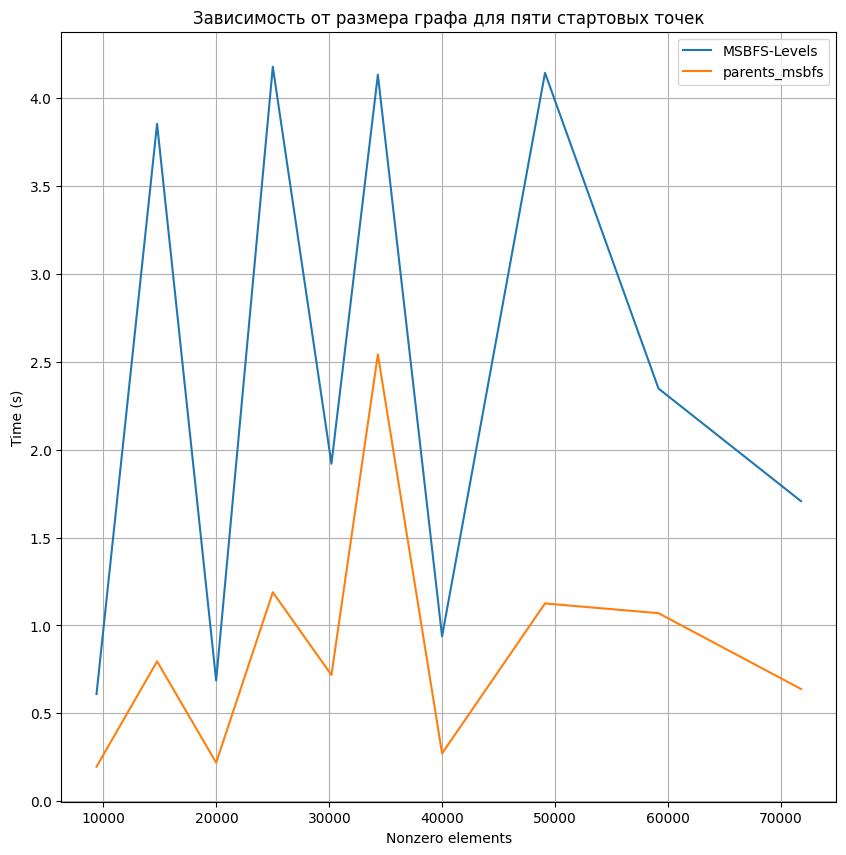

In [35]:
nonzero_count_list = list(results.keys())
level_time = [results[count][0] for count in nonzero_count_list]
parents_time = [results[count][1] for count in nonzero_count_list]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(nonzero_count_list, level_time, label='MSBFS-Levels')
ax.plot(nonzero_count_list, parents_time, label='parents_msbfs')
ax.set_xlabel('Nonzero elements')
ax.set_ylabel('Time (s)')
ax.set_title('Зависимость от размера графа для пяти стартовых точек')
ax.legend()
ax.grid(True)

In [16]:
# Генератор случайных неориентированных графов
import random
def generate_random_graph(num_vertices, sparsity):
  np_zeros = np.zeros((num_vertices, num_vertices))
  adjacency_matrix = gb.Matrix.from_dense(np_zeros, missing_value=0)
  for i in range(num_vertices):
      for j in range(i, num_vertices):
          if random.random() < sparsity:
              if i == j:
                  adjacency_matrix[i, j] = 1
              else:
                  adjacency_matrix[i, j] = 1
                  adjacency_matrix[j, i] = 1

  return adjacency_matrix

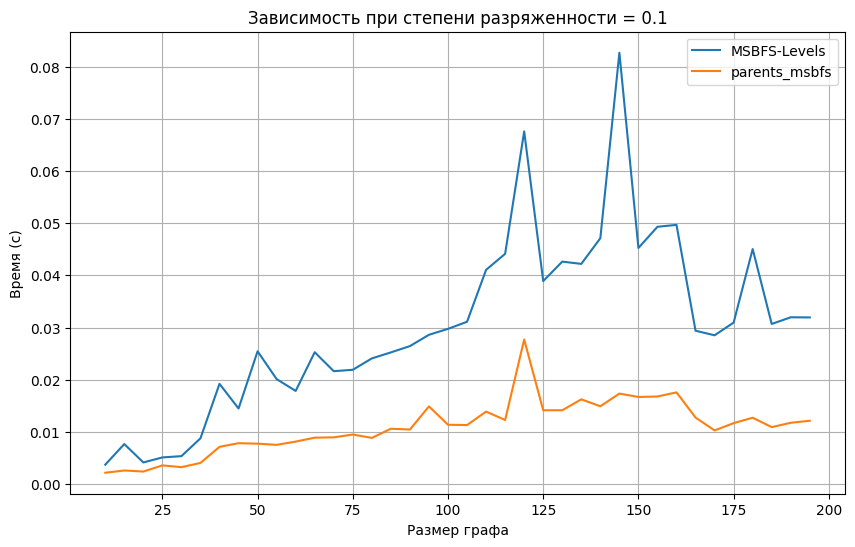

In [19]:
results_random = {}
for num_vertices in np.arange(10, 200, 5):
    graph = generate_random_graph(num_vertices, sparsity=0.1)
    times = calculate_time(graph, [1,2])
    results_random[num_vertices] = times

num_vertices_list = list(results_random.keys())
level_time = [results_random[count][0] for count in num_vertices_list]
parents_time = [results_random[count][1] for count in num_vertices_list]


fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(num_vertices_list, level_time, label='MSBFS-Levels')
ax.plot(num_vertices_list, parents_time, label='parents_msbfs')

ax.set_xlabel('Размер графа')
ax.set_ylabel('Время (с)')
ax.set_title('Зависимость при степени разряженности = 0.1 для двух стартовых точек')
ax.legend()
ax.grid(True)
plt.show()

**Выводы:**



*   Увеличение стартовых точек ведет к увеличению времени работы обоих алгоритмов
*   parents_msbfs оказался чуть быстрее алгоритма MSBFS-Levels



## Оценка производительности при использовании других полуколец

In [29]:
def calculate_time_semiring(A, start_points):
    start_time = time.time()
    calculate_msbfs_levels(A, start_points)
    level_time_any_pair = time.time() - start_time

    start_time = time.time()
    find_parents_msbfs(A, start_points)
    parents_time_min_first = time.time() - start_time

    start_time = time.time()
    calculate_msbfs_levels(A, start_points, semiring.min_first)
    level_time_min_first = time.time() - start_time

    start_time = time.time()
    find_parents_msbfs(A, start_points, semiring.any_pair)
    parents_time_any_pair = time.time() - start_time

    return level_time_any_pair, parents_time_min_first, level_time_min_first, parents_time_any_pair

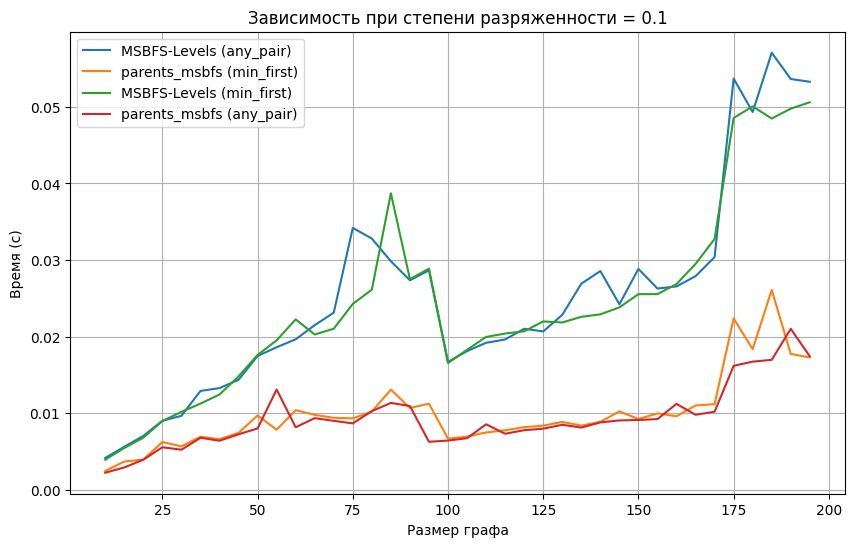

In [30]:
results_random = {}
for num_vertices in np.arange(10, 200, 5):
    graph = generate_random_graph(num_vertices, sparsity=0.1)
    times = calculate_time_semiring(graph, [1,2])
    results_random[num_vertices] = times

num_vertices_list = list(results_random.keys())
level_time_any_pair = [results_random[count][0] for count in num_vertices_list]
parents_time_min_first = [results_random[count][1] for count in num_vertices_list]
level_time_min_first = [results_random[count][2] for count in num_vertices_list]
parents_time_any_pair = [results_random[count][3] for count in num_vertices_list]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(num_vertices_list, level_time_any_pair, label='MSBFS-Levels (any_pair)')
ax.plot(num_vertices_list, parents_time_min_first, label='parents_msbfs (min_first)')
ax.plot(num_vertices_list, level_time_min_first, label='MSBFS-Levels (min_first)')
ax.plot(num_vertices_list, parents_time_any_pair, label='parents_msbfs (any_pair)')

ax.set_xlabel('Размер графа')
ax.set_ylabel('Время (с)')
ax.set_title('Зависимость при степени разряженности = 0.1')
ax.legend()
ax.grid(True)
plt.show()

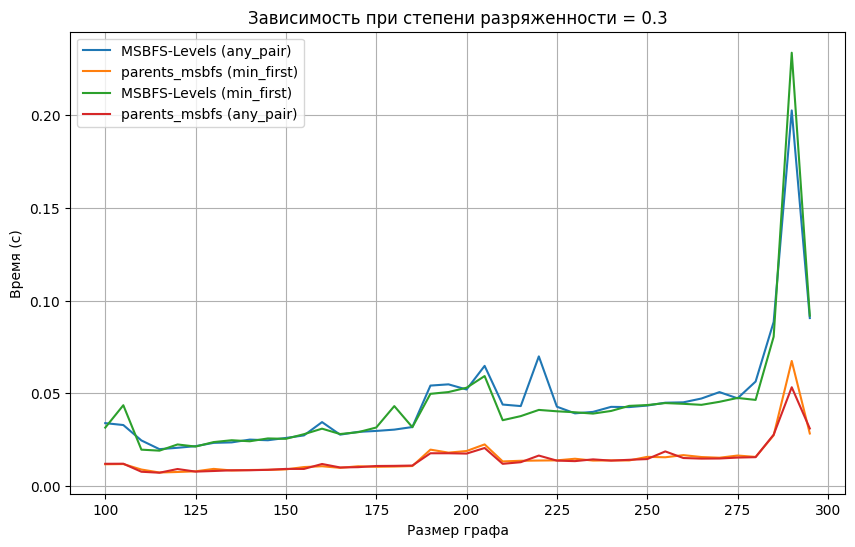

In [33]:
results_random = {}
for num_vertices in np.arange(100, 300, 5):
    graph = generate_random_graph(num_vertices, sparsity=0.3)
    times = calculate_time_semiring(graph, [1,2])
    results_random[num_vertices] = times

num_vertices_list = list(results_random.keys())
level_time_any_pair = [results_random[count][0] for count in num_vertices_list]
parents_time_min_first = [results_random[count][1] for count in num_vertices_list]
level_time_min_first = [results_random[count][2] for count in num_vertices_list]
parents_time_any_pair = [results_random[count][3] for count in num_vertices_list]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(num_vertices_list, level_time_any_pair, label='MSBFS-Levels (any_pair)')
ax.plot(num_vertices_list, parents_time_min_first, label='parents_msbfs (min_first)')
ax.plot(num_vertices_list, level_time_min_first, label='MSBFS-Levels (min_first)')
ax.plot(num_vertices_list, parents_time_any_pair, label='parents_msbfs (any_pair)')

ax.set_xlabel('Размер графа')
ax.set_ylabel('Время (с)')
ax.set_title('Зависимость при степени разряженности = 0.3')
ax.legend()
ax.grid(True)
plt.show()

**Выводы:**

Для сгененированных данных различие между разными полукольцами незначительное при различной степени разряженности и для разного размера графа